# data load

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn import metrics

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, Input, LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from tensorflow.keras.layers import GRU, Conv1D, MaxPooling1D, Flatten, BatchNormalization, GlobalAveragePooling1D, AveragePooling1D, Average, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
train =  pd.read_csv("/content/drive/MyDrive/Parrot_teamproject/train.csv")
test =  pd.read_csv("/content/drive/MyDrive/Parrot_teamproject/test.csv")
test_labels =  pd.read_csv("/content/drive/MyDrive/Parrot_teamproject/test_labels.csv")
submission =  pd.read_csv("/content/drive/MyDrive/Parrot_teamproject/sample_submission.csv")

In [5]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [7]:
test_labels.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [8]:
submission.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5
1,0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5
2,00013b17ad220c46,0.5,0.5,0.5,0.5,0.5,0.5
3,00017563c3f7919a,0.5,0.5,0.5,0.5,0.5,0.5
4,00017695ad8997eb,0.5,0.5,0.5,0.5,0.5,0.5


In [9]:
print(train.shape)
print(test.shape)
print(test_labels.shape)
print(submission.shape)

(159571, 8)
(153164, 2)
(153164, 7)
(153164, 7)


In [10]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [11]:
train_x = train['comment_text']
test_x = test['comment_text']
train_y = train[labels].values

In [12]:
print('훈련용 코멘트 : {}'.format(len(train_x)))
print('테스트용 코멘트 : {}'.format(len(test_x)))
num_classes = 6
print('카테고리 : {}'.format(num_classes))

훈련용 코멘트 : 159571
테스트용 코멘트 : 153164
카테고리 : 6


In [13]:
train_x[:10]

0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
5    "\n\nCongratulations from me as well, use the ...
6         COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
7    Your vandalism to the Matt Shirvington article...
8    Sorry if the word 'nonsense' was offensive to ...
9    alignment on this subject and which are contra...
Name: comment_text, dtype: object

In [14]:
train_y[:5]

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

# eda

In [15]:
def acc_loss_plot(hist):
    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'y', label='train loss')
    loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc = 'upper left')

    acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
    acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
    acc_ax.set_ylabel('accuracy')
    acc_ax.legend(loc='upper right')

    plt.show()

In [16]:
train_length = train_x.apply(len)
train_length.head()

0    264
1    112
2    233
3    622
4     67
Name: comment_text, dtype: int64

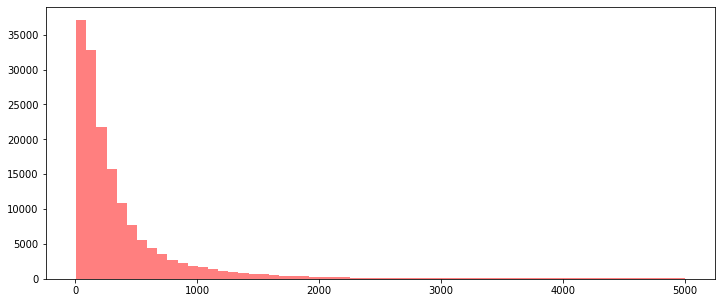

In [17]:
plt.figure(figsize = (12, 5))
plt.hist(train_length, bins = 60, alpha = 0.5, color = 'r')
plt.show()

In [18]:
print("max length : ", np.max(train_length))
print("min length : ", np.min(train_length))
print("mean length : ", np.mean(train_length))
print("75 % percentile : ", np.percentile(train_length, 75))
print("85 % percentile : ", np.percentile(train_length, 85))
print("std length : ", np.std(train_length))

max length :  5000
min length :  6
mean length :  394.0732213246768
75 % percentile :  435.0
85 % percentile :  663.0
std length :  590.7184309382149


In [19]:
def acc_loss_plot(hist):
    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'y', label='train loss')
    loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc = 'upper left')

    acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
    acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
    acc_ax.set_ylabel('accuracy')
    acc_ax.legend(loc='upper right')

    plt.show()

# preprocessing

## stopwords

In [20]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [21]:
train_x = list(train_x)

In [22]:
train_x[:10]

["Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",
 "D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)",
 "Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",
 '"\nMore\nI can\'t make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on r

사실 stopwords만 제거한 건 아닙니다.. 정규표현식 보시면 아시겠지만 stopwords를 제거한 다음에

1.   \n을 없애고
2.   문자나 숫자, whitespace(\n이나 \t 같은 것들)을 제외한(^표현) 것들, 즉 punctuation을 없애고
3.   공백을 기준으로 split해 문자열을 나눠주는 clean_text()입니다.


이것을 train_x(원래는 dataframe에서 열을 뽑아온 것이기 때문에 Series였으나 위에서 list로 형변환을 해주었습니다)에 적용시켰습니다!



In [23]:
from tqdm import tqdm
import re

def clean_text(text, remove_stopwords = True):
    output = ""
    text = str(text).replace("\n", "")
    text = re.sub(r'[^\w\s]','',text).lower()
    if remove_stopwords:
        text = text.split(" ")
        for word in text:
            if word not in stopwords.words("english"):
                output = output + " " + word
    else:
        output = text
    return str(output.strip())[1:-3].replace("  ", " ")
    
texts = [] 

for line in tqdm(train_x, total=train.shape[0]): 
    texts.append(clean_text(line))

100%|██████████| 159571/159571 [16:51<00:00, 157.69it/s]


In [24]:
print('Original data:', train_x[1], train_y[1])
print('Length of original data:', len(train_x[1]))
print('Cleaned data:', texts[1], train_y[1])
print('Length of cleaned data:', len(texts[1]))

Original data: D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC) [0 0 0 0 0 0]
Length of original data: 112
Cleaned data: aww matches background colour im seemingly stuck thanks talk 2151 january 11 2016  [0 0 0 0 0 0]
Length of cleaned data: 82


제가 시도해본 건 저번 발표 때 왜 maxlen을 200이나 250값으로 주는지에 대해 타당한 고민을 해본 분이 계셔서...
저도 그렇다면 

max_len(학습할 문자열의 최대 길이) = 전처리를 거친 문자열의 평균 길이

로 하고 싶어서 코드를 짜봤지만 미숙해서ㅜㅠ 다음 시간까지 해와보도록 하겠습니다!

In [25]:
cleaned_train_length = texts.apply(len)
print("mean length : ", np.mean(cleaned_train_length))

AttributeError: ignored

## tokenize

maxlen을 뭔가 더 의미있는 값으로 해주고 싶었지만... 일단 고정된 값으로 해보겠습니다

In [26]:
maxlen = 200
max_words = 25000
embeding_dim = 100

In [27]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=max_words)

# Fit the tokenizer on the comments 
tokenizer.fit_on_texts(texts)

# Get the word index of the top 20000 words from the dataset
word_idx = tokenizer.word_index

# Convert the string sentence to a sequence of their numerical values
sequences = tokenizer.texts_to_sequences(texts)

# Pad the sequences to make them of uniform length
padded_sequences = pad_sequences(sequences, maxlen = maxlen, padding = 'post')

In [28]:
print('Vocabulary size:', len(word_idx))
print("\n\nThe tokenized sequence:\n")
print(sequences[1])
print("\n\nThe padded sequence:\n")
print(padded_sequences[1])

Vocabulary size: 324669


The tokenized sequence:

[2410, 1342, 3714, 16, 4181, 2496, 70, 9, 934, 1064, 8267]


The padded sequence:

[2410 1342 3714   16 4181 2496   70    9  934 1064 8267    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    

In [29]:
print('Shape of data tensor:', padded_sequences.shape)
print('Shape of label tensor:', train_y.shape)

Shape of data tensor: (159571, 200)
Shape of label tensor: (159571, 6)


In [30]:
# Shuffling data
indices = np.arange(padded_sequences.shape[0])
np.random.shuffle(indices)
train_x = padded_sequences[indices]
train_y = train_y[indices]

In [31]:
print('Tokenized random sentences: \n', train_x[1])
print('One hot label: \n', train_y[1])

Tokenized random sentences: 
 [  280    73   321   313   149  2840  1946   187    80    45    20  3412
   942   706     3 10042     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0   

In [32]:
from numpy import array, asarray, zeros

embeddings_dictionary = {}

glove_file = open('/content/drive/MyDrive/Parrot_teamproject/glove.6B.100d.txt.zip (Unzipped Files)/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

print('Found %s numbers of vector' % len(embeddings_dictionary))

Found 400000 numbers of vector


In [33]:
embedding_matrix = zeros((max_words, embeding_dim))
for word, index in tokenizer.word_index.items():
  if index < max_words:
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

# models

## model_1 (transformer block)

아직 GloVe를 적용시키는 방법은 모르겠어요,,

https://keras.io/examples/nlp/text_classification_with_transformer/
와 transformer 논문을 참고했습니다

In [34]:
num_heads = 8  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

In [35]:
from tensorflow import keras
from tensorflow.keras import layers

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [36]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [37]:
inputs = Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, max_words, embeding_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embeding_dim, num_heads, ff_dim)
x = transformer_block(x)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.1)(x)
outputs = Dense(6, activation="sigmoid")(x)
model_1 = Model(inputs=inputs, outputs=outputs)

model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
token_and_position_embedding (None, 200, 100)          2520000   
_________________________________________________________________
transformer_block (Transform (None, 200, 100)          329432    
_________________________________________________________________
global_average_pooling1d (Gl (None, 100)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                6464      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0     

In [38]:
model_1.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])

In [39]:
early_stopping = EarlyStopping(monitor = 'val_loss', mode='min', patience = 2)
hist_1 = model_1.fit(train_x, train_y, batch_size = 128, epochs = 10, validation_split=0.2, callbacks = [early_stopping])

Epoch 1/10
998/998 [==============================] - 72s 70ms/step - loss: 0.1267 - accuracy: 0.7842 - val_loss: 0.0643 - val_accuracy: 0.9943
Epoch 2/10
998/998 [==============================] - 69s 69ms/step - loss: 0.0560 - accuracy: 0.9545 - val_loss: 0.0598 - val_accuracy: 0.9935
Epoch 3/10
998/998 [==============================] - 69s 69ms/step - loss: 0.0493 - accuracy: 0.9013 - val_loss: 0.0659 - val_accuracy: 0.9935
Epoch 4/10
998/998 [==============================] - 69s 69ms/step - loss: 0.0431 - accuracy: 0.8762 - val_loss: 0.0677 - val_accuracy: 0.9737


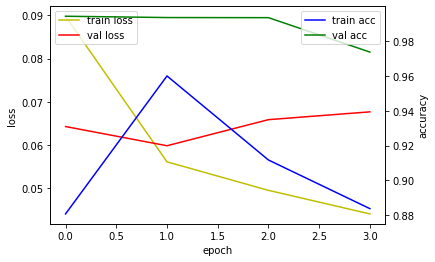

In [40]:
acc_loss_plot(hist_1)

## model_2 (Bidirectional LSTM)

In [41]:
def model_LSTM(num_classes):
    inp = Input(shape = (maxlen, ))
    layer = Embedding(max_words, 
                      embeding_dim,
                      weights = [embedding_matrix],
                      trainable=False)(inp)
    layer = Bidirectional(LSTM(50, return_sequences = True, recurrent_dropout = 0.15))(layer)
    layer = GlobalMaxPool1D()(layer)
    layer = Dropout(0.2)(layer)
    layer = Dense(50, activation = 'relu')(layer)
    layer = Dropout(0.2)(layer)
    layer = Dense(num_classes, activation = 'sigmoid')(layer)
    model = Model(inputs = inp, outputs = layer)
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    return model

In [42]:
model_2 = model_LSTM(6)
model_2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 200, 100)          2500000   
_________________________________________________________________
bidirectional (Bidirectional (None, 200, 100)          60400     
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0   

In [43]:
hist_2 = model_2.fit(train_x, train_y, batch_size = 128, epochs = 10, validation_split=0.2, callbacks = [early_stopping])

Epoch 1/10
998/998 [==============================] - 823s 822ms/step - loss: 0.1417 - accuracy: 0.6549 - val_loss: 0.0708 - val_accuracy: 0.9943
Epoch 2/10
998/998 [==============================] - 812s 814ms/step - loss: 0.0714 - accuracy: 0.9593 - val_loss: 0.0659 - val_accuracy: 0.9943
Epoch 3/10
998/998 [==============================] - 808s 810ms/step - loss: 0.0640 - accuracy: 0.9860 - val_loss: 0.0638 - val_accuracy: 0.9943
Epoch 4/10
998/998 [==============================] - 805s 806ms/step - loss: 0.0618 - accuracy: 0.9908 - val_loss: 0.0625 - val_accuracy: 0.9943
Epoch 5/10
998/998 [==============================] - 840s 842ms/step - loss: 0.0595 - accuracy: 0.9912 - val_loss: 0.0627 - val_accuracy: 0.9943
Epoch 6/10
998/998 [==============================] - 838s 840ms/step - loss: 0.0571 - accuracy: 0.9924 - val_loss: 0.0630 - val_accuracy: 0.9943


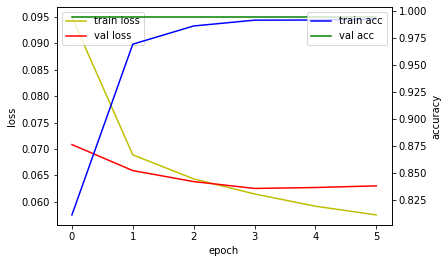

In [44]:
acc_loss_plot(hist_2)

## model_3 (CNN)

In [45]:
def model_CNN(num_classes):
    inp = Input(shape = (maxlen, ))
    layer = Embedding(max_words, 
                      embeding_dim,
                      weights = [embedding_matrix],
                      trainable=False)(inp)
    #CNNlayer1
    layer = Conv1D(64, 5, padding='same', activation='relu')(layer)
    layer = BatchNormalization()(layer)
    layer = MaxPooling1D(5)(layer)
    #CNNlayer2
    layer = Conv1D(64, 5, padding='same', activation='relu')(layer)
    layer = BatchNormalization()(layer)
    layer = MaxPooling1D(3)(layer)
    #CNNlayer3
    layer = Conv1D(64, 5, padding='same', activation='relu')(layer)
    layer = BatchNormalization()(layer)
    layer = MaxPooling1D(3)(layer)
    #CNNlayer4
    layer = Conv1D(64, 5, padding='same', activation='relu')(layer)
    layer = BatchNormalization()(layer)
    layer = MaxPooling1D(3)(layer)
    #Dense
    layer = Flatten()(layer)
    layer = Dense(64, activation='relu')(layer)
    layer = Dropout(0.2)(layer)
    layer = Dense(num_classes, activation = 'sigmoid')(layer)
    model = Model(inputs = inp, outputs = layer)
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    return model

In [46]:
model_3 = model_CNN(6)
model_3.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 200, 100)          2500000   
_________________________________________________________________
conv1d (Conv1D)              (None, 200, 64)           32064     
_________________________________________________________________
batch_normalization (BatchNo (None, 200, 64)           256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 40, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 40, 64)            20544     
_________________________________________________________________
batch_normalization_1 (Batch (None, 40, 64)            256 

In [47]:
hist_3 = model_3.fit(train_x, train_y, batch_size = 64, epochs = 10, validation_split=0.2, callbacks = [early_stopping])

Epoch 1/10
1995/1995 [==============================] - 30s 7ms/step - loss: 0.1047 - accuracy: 0.7015 - val_loss: 0.0722 - val_accuracy: 0.9715
Epoch 2/10
1995/1995 [==============================] - 14s 7ms/step - loss: 0.0670 - accuracy: 0.9704 - val_loss: 0.0687 - val_accuracy: 0.9943
Epoch 3/10
1995/1995 [==============================] - 14s 7ms/step - loss: 0.0608 - accuracy: 0.9901 - val_loss: 0.0688 - val_accuracy: 0.9842
Epoch 4/10
1995/1995 [==============================] - 14s 7ms/step - loss: 0.0576 - accuracy: 0.9896 - val_loss: 0.0690 - val_accuracy: 0.9943


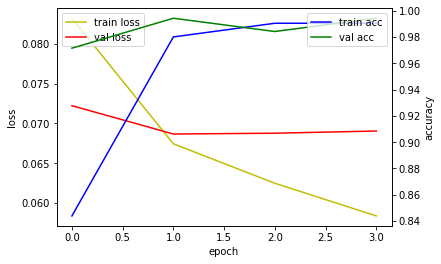

In [48]:
acc_loss_plot(hist_3)

## model_4 (CNN+GRU)

In [81]:
def model_GRU(num_classes):
    inp = Input(shape = (maxlen, ))
    layer = Embedding(max_words, 
                      embeding_dim,
                      weights = [embedding_matrix],
                      trainable=False)(inp)
    layer = Conv1D(32, 5, padding='same', activation='relu')(layer)
    layer = MaxPooling1D(3)(layer)
    later = Conv1D(32, 5, padding='same', activation='relu')(layer)
    layer = GRU(32, dropout=0.2, recurrent_dropout=0.5)(layer)
    layer = Dense(num_classes, activation = 'sigmoid')(layer)
    model = Model(inputs = inp, outputs = layer)
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    return model

In [82]:
model_4 = model_GRU(6)
model_4.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 200, 100)          2500000   
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 200, 32)           16032     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 66, 32)            0         
_________________________________________________________________
gru_4 (GRU)                  (None, 32)                6336      
_________________________________________________________________
dense_14 (Dense)             (None, 6)                 198       
Total params: 2,522,566
Trainable params: 22,566
Non-trainable params: 2,500,000
____________________________________________

In [83]:
early_stop = EarlyStopping(monitor = 'val_accuracy', mode='max', patience = 3)
hist_4 = model_4.fit(train_x, train_y, batch_size = 128, epochs = 10, validation_split=0.2, callbacks = [early_stop])

Epoch 1/10
998/998 [==============================] - 173s 171ms/step - loss: 0.2130 - accuracy: 0.7300 - val_loss: 0.0785 - val_accuracy: 0.9897
Epoch 2/10
998/998 [==============================] - 167s 168ms/step - loss: 0.0753 - accuracy: 0.9933 - val_loss: 0.0707 - val_accuracy: 0.9897
Epoch 3/10
998/998 [==============================] - 167s 167ms/step - loss: 0.0698 - accuracy: 0.9922 - val_loss: 0.0687 - val_accuracy: 0.9924
Epoch 4/10
998/998 [==============================] - 168s 168ms/step - loss: 0.0644 - accuracy: 0.9935 - val_loss: 0.0678 - val_accuracy: 0.9901
Epoch 5/10
998/998 [==============================] - 166s 166ms/step - loss: 0.0613 - accuracy: 0.9930 - val_loss: 0.0678 - val_accuracy: 0.9929
Epoch 6/10
998/998 [==============================] - 170s 170ms/step - loss: 0.0603 - accuracy: 0.9927 - val_loss: 0.0671 - val_accuracy: 0.9938
Epoch 7/10
998/998 [==============================] - 173s 173ms/step - loss: 0.0581 - accuracy: 0.9929 - val_loss: 0.0670 -

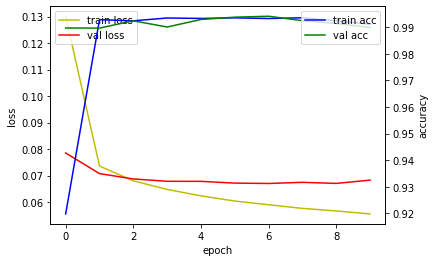

In [84]:
acc_loss_plot(hist_4)

# predict and submit

In [49]:
test_x = list(test_x)

In [50]:
test_x[:10]

["Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,",
 '== From RfC == \n\n The title is fine as it is, IMO.',
 '" \n\n == Sources == \n\n * Zawe Ashton on Lapland —  /  "',
 ":If you have a look back at the source, the information I updated was the correct form. I can only guess the source hadn't updated. I shall update the information once again but thank you for your message.",
 "I don't anonymously edit articles at all.",
 'Thank you for understanding. I think very highly of you and would not revert without discussion.',
 'Please do not add nonsense to Wikipedia. Such edits are considered vandalism and quickly undone. If you would like to experiment, please use the sand

In [51]:
texts_test = [] 

for line in tqdm(test_x, total=test.shape[0]): 
    texts_test.append(clean_text(line))

100%|██████████| 153164/153164 [15:30<00:00, 164.54it/s]


In [52]:
sequences_test = tokenizer.texts_to_sequences(texts_test)

In [53]:
padded_sequences_test = pad_sequences(sequences_test, maxlen = maxlen, padding = 'post')

In [54]:
# Prediction for test data
predict_1 = model_1.predict(padded_sequences_test)
predict_2 = model_2.predict(padded_sequences_test)
predict_3 = model_3.predict(padded_sequences_test)

In [85]:
predict_4 = model_4.predict(padded_sequences_test)

In [55]:
sub_t =  pd.read_csv("/content/drive/MyDrive/Parrot_teamproject/sample_submission.csv")
sub_b =  pd.read_csv("/content/drive/MyDrive/Parrot_teamproject/sample_submission.csv")
sub_c =  pd.read_csv("/content/drive/MyDrive/Parrot_teamproject/sample_submission.csv")

In [86]:
sub_g =  pd.read_csv("/content/drive/MyDrive/Parrot_teamproject/sample_submission.csv")

In [56]:
sub_t.iloc[:,1:] = predict_1
sub_b.iloc[:,1:] = predict_2
sub_c.iloc[:,1:] = predict_3

In [87]:
sub_g.iloc[:,1:] = predict_4

In [57]:
sub_t.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.986286,2.061121e-01,0.951152,2.922674e-02,0.788706,0.097901
1,0000247867823ef7,0.000221,4.615256e-07,0.000212,2.216864e-06,0.000101,0.000009
2,00013b17ad220c46,0.119276,8.371370e-04,0.025235,1.427804e-03,0.039575,0.003592
3,00017563c3f7919a,0.000309,6.867744e-08,0.000086,6.301457e-07,0.000042,0.000007
4,00017695ad8997eb,0.000632,1.261821e-06,0.000259,1.194472e-05,0.000165,0.000038


In [58]:
sub_b.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.996182,3.562774e-01,0.914543,0.123188,0.822440,0.398610
1,0000247867823ef7,0.003378,8.206709e-06,0.001049,0.000019,0.000675,0.000034
2,00013b17ad220c46,0.106793,9.505486e-03,0.049777,0.010334,0.053563,0.010390
3,00017563c3f7919a,0.002085,9.407991e-07,0.000396,0.000002,0.000250,0.000004
4,00017695ad8997eb,0.003449,1.227828e-05,0.000913,0.000026,0.000789,0.000024


In [59]:
sub_c.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.977438,1.305557e-01,0.878032,0.055419,0.736574,0.130435
1,0000247867823ef7,0.009848,9.765324e-06,0.001506,0.000027,0.001587,0.000063
2,00013b17ad220c46,0.075515,2.547881e-03,0.018883,0.000700,0.022378,0.003101
3,00017563c3f7919a,0.012209,1.006284e-07,0.000457,0.000001,0.000792,0.000002
4,00017695ad8997eb,0.035011,5.298536e-05,0.005701,0.000083,0.005976,0.000192


In [88]:
sub_g.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.982989,0.247311,0.921962,0.060112,0.868074,0.201268
1,0000247867823ef7,0.007085,0.000116,0.002077,0.000220,0.001906,0.000162
2,00013b17ad220c46,0.157742,0.004859,0.064418,0.005649,0.071668,0.009988
3,00017563c3f7919a,0.001710,0.000038,0.000443,0.000091,0.000464,0.000045
4,00017695ad8997eb,0.009715,0.000127,0.002229,0.000260,0.002509,0.000203


In [63]:
sub_t.to_csv('/content/drive/MyDrive/Parrot/toxic_0407_1.csv', index=False)

In [64]:
sub_b.to_csv('/content/drive/MyDrive/Parrot/toxic_0407_2.csv', index=False)

In [65]:
sub_c.to_csv('/content/drive/MyDrive/Parrot/toxic_0407_3.csv', index=False)

In [89]:
sub_g.to_csv('/content/drive/MyDrive/Parrot/toxic_0407_4.csv', index=False)

In [66]:
model_2.save('/content/drive/MyDrive/Parrot/base_bidirLSTM.h5')